In [34]:
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\larac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
pip install paho-mqtt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\larac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\larac\AppData\Local\Temp\ipykernel_28264\4271411706.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


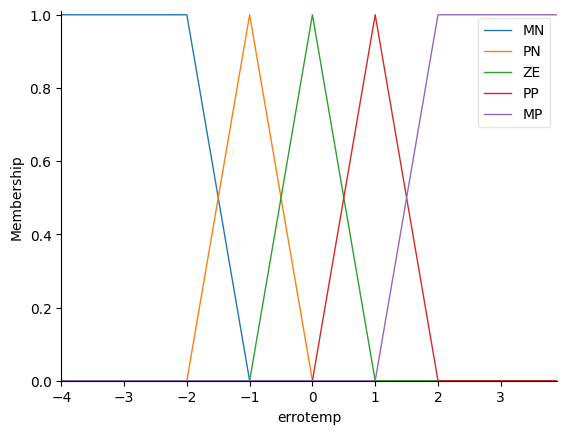

In [36]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org"
client = mqtt.Client()
client.connect(mqttBroker)

# New Antecedent/Consequent objects hold universe variables and membership
# functions
errotemp = ctrl.Antecedent(np.arange(-4, 4, 0.1), 'errotemp')
varerrotemp =ctrl.Antecedent(np.arange(-1, 1, 0.01), 'varerrotemp')
aquecedor =ctrl.Consequent(np.arange(0, 101, 1), 'aquecedor')


# Custom membership functions can be built interactively with a familiar,
# Pythonic API
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-4, -4, -2,-1])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-2,-1,0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-1, 0, 1])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 1, 2])
errotemp['MP'] = fuzz.trapmf(errotemp.universe,[1, 2, 4, 4])
# You can see how these look with .view()
errotemp.view()

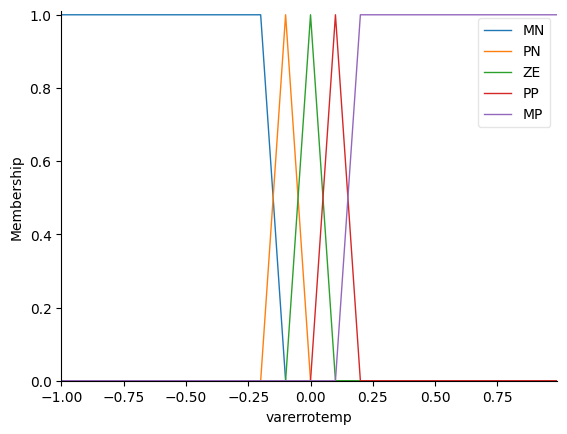

In [37]:
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-1, -1, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, 1, 1])
# You can see how these look with .view()
varerrotemp.view()

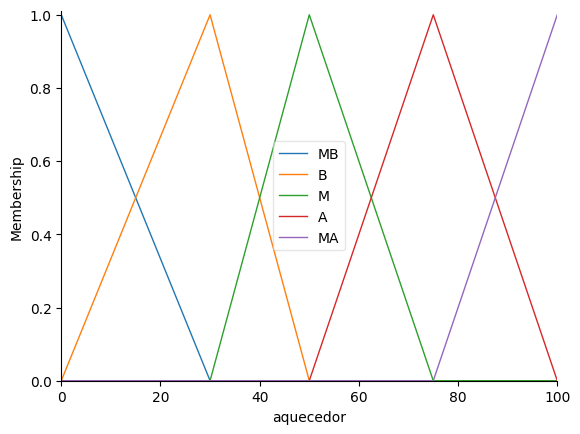

In [38]:
aquecedor['MB'] = fuzz.trimf(aquecedor.universe, [0,0,30])
aquecedor['B'] = fuzz.trimf(aquecedor.universe, [0,30,50])
aquecedor['M'] = fuzz.trimf(aquecedor.universe, [30, 50, 75])
aquecedor['A'] = fuzz.trimf(aquecedor.universe, [50, 75, 100])
aquecedor['MA'] = fuzz.trimf(aquecedor.universe, [75, 100, 100])
aquecedor.view()

In [39]:
# --- CRIAÇÃO DAS REGRAS FUZZY (LÓGICA DE RESFRIAMENTO) ---

regras_corrigidas = [
    # 1. Erro é MP (Muito Positivo = MUITO QUENTE) -> Precisa de Potência Alta
    ctrl.Rule(errotemp['MP'] & varerrotemp['MN'], aquecedor['M']),
    ctrl.Rule(errotemp['MP'] & varerrotemp['PN'], aquecedor['A']),
    ctrl.Rule(errotemp['MP'] & varerrotemp['ZE'], aquecedor['MA']),
    ctrl.Rule(errotemp['MP'] & varerrotemp['PP'], aquecedor['MA']),
    ctrl.Rule(errotemp['MP'] & varerrotemp['MP'], aquecedor['MA']),

    # 2. Erro é PP (Pouco Positivo = Pouco Quente)
    ctrl.Rule(errotemp['PP'] & varerrotemp['MN'], aquecedor['B']),
    ctrl.Rule(errotemp['PP'] & varerrotemp['PN'], aquecedor['M']),
    ctrl.Rule(errotemp['PP'] & varerrotemp['ZE'], aquecedor['A']),
    ctrl.Rule(errotemp['PP'] & varerrotemp['PP'], aquecedor['A']),
    ctrl.Rule(errotemp['PP'] & varerrotemp['MP'], aquecedor['MA']),

    # 3. Erro é ZE (No Setpoint)
    ctrl.Rule(errotemp['ZE'] & varerrotemp['MN'], aquecedor['MB']),
    ctrl.Rule(errotemp['ZE'] & varerrotemp['PN'], aquecedor['B']),
    ctrl.Rule(errotemp['ZE'] & varerrotemp['ZE'], aquecedor['M']),
    ctrl.Rule(errotemp['ZE'] & varerrotemp['PP'], aquecedor['A']),
    ctrl.Rule(errotemp['ZE'] & varerrotemp['MP'], aquecedor['A']),

    # 4. Erro é PN (Pouco Negativo = Pouco Frio)
    ctrl.Rule(errotemp['PN'] & varerrotemp['MN'], aquecedor['MB']),
    ctrl.Rule(errotemp['PN'] & varerrotemp['PN'], aquecedor['MB']),
    ctrl.Rule(errotemp['PN'] & varerrotemp['ZE'], aquecedor['B']),
    ctrl.Rule(errotemp['PN'] & varerrotemp['PP'], aquecedor['M']),
    ctrl.Rule(errotemp['PN'] & varerrotemp['MP'], aquecedor['A']),

    # 5. Erro é MN (Muito Negativo = MUITO FRIO) -> Precisa de Potência Baixa
    ctrl.Rule(errotemp['MN'] & varerrotemp['MN'], aquecedor['MB']),
    ctrl.Rule(errotemp['MN'] & varerrotemp['PN'], aquecedor['MB']),
    ctrl.Rule(errotemp['MN'] & varerrotemp['ZE'], aquecedor['MB']),
    ctrl.Rule(errotemp['MN'] & varerrotemp['PP'], aquecedor['B']),
    ctrl.Rule(errotemp['MN'] & varerrotemp['MP'], aquecedor['M'])
]

# --- AJUSTE FINAL DO SISTEMA DE CONTROLE ---
sistema_crac = ctrl.ControlSystem(regras_corrigidas)
simulador_potencia = ctrl.ControlSystemSimulation(sistema_crac)

In [40]:
# --- CRIAÇÃO DO SISTEMA DE CONTROLE (ControlSystem) ---
# O objeto 'sistema_crac' recebe a lista 'regras' (as 25 regras PD corrigidas).
sistema_crac = ctrl.ControlSystem(regras) 

# --- CRIAÇÃO DO SIMULADOR (ControlSystemSimulation) ---
# O simulador é o que permite injetar os valores de erro e obter a saída de potência.
simulador_potencia = ctrl.ControlSystemSimulation(sistema_crac)

In [41]:
import numpy as np
import math

# --- 1. MODELAGEM DINÂMICA DA TEMPERATURA EXTERNA (RF5) ---
def gerar_temp_externa(passo_minuto, T_s=1440):
    """Gera a temperatura externa T_ext para um dado minuto (t)."""
    # Parâmetros
    T_base = 22.5
    A = 7.5
    phi = -np.pi / 2  # Desloca para o pico ser ao meio-dia
    
    # Ruído Gaussiano (perturbações aleatórias realistas)
    ruido = np.random.normal(0, 0.5) 
    
    # Cálculo senoidal
    tempo_rad = (2 * np.pi * passo_minuto) / T_s + phi
    T_ext = T_base + A * np.sin(tempo_rad) + ruido
    
    # Limita o universo de discurso obrigatório [10, 35]°C
    return np.clip(T_ext, 10, 35)

# --- 2. MODELAGEM DINÂMICA DA CARGA TÉRMICA (RF5) ---
def gerar_carga_termica(passo_minuto, T_s=1440):
    """Gera a carga térmica Q_est para um dado minuto (t)."""
    
    minuto_no_dia = passo_minuto % 1440
    ruido_q = np.random.normal(0, 2)
    
    if minuto_no_dia < 360:  # 00:00 - 06:00 (Baixa)
        Q_base = 40 
    elif minuto_no_dia < 1080:  # 06:00 - 18:00 (Pico)
        Q_base = 80 
    else:  # 18:00 - 24:00 (Média)
        Q_base = 60
        
    Q_est = Q_base + ruido_q
    
    # Limita o universo de discurso obrigatório [0, 100]%
    return np.clip(Q_est, 0, 100)

In [ ]:
# --- PARÂMETROS E CONDIÇÕES INICIAIS DO PROJETO ---
SP = 22.0  # Setpoint CORRIGIDO (22°C, conforme requisito)
T_S_MINUTES = 1440  # Duração total da simulação (24 horas)

T_n = 22.0       # T(0) = 22C
P_CRAC_n = 50.0  # P_CRAC(0) = 50%
erro_n = T_n - SP 
max_potencia_tempo = 0 # Para cálculo de Alerta de Eficiência

print(f"Início da Simulação (24h/1440 passos). Setpoint: {SP}°C")
print("-" * 50)

# O loop é limitado a 1440 iterações (24h * 60min)
for passo_minuto in range(1, T_S_MINUTES + 1):
    
    # 1. Preparação
    erroanterior = erro_n
    
    # 2. Obter Inputs Dinâmicos (T_ext e Q_est)
    T_ext = gerar_temp_externa(passo_minuto)
    Q_est = gerar_carga_termica(passo_minuto)
    
    # 3. Cálculo do Erro (Input PD)
    erroatual = T_n - SP
    varerroTemp = erroatual - erroanterior
    
    # 4. Executar o Motor Fuzzy (PD Base)
    simulador_potencia.input['errotemp'] = erroatual
    simulador_potencia.input['varerrotemp'] = varerroTemp
    try:
        simulador_potencia.compute()
        p_crac_base = simulador_potencia.output.get('aquecedor', P_CRAC_n) # Usa o nome 'aquecedor' do seu Consequent
    except Exception as e:
        print(f"Erro no simulador fuzzy: {e}")
        p_crac_base = P_CRAC_n
    
    # 5. Ajuste MISO (Modulação de Ganho/Bias) - Ganhos corrigidos para estabilidade
    ajuste_ext = (T_ext - 22.5) * 0.2  # Ajuste ainda mais moderado para T_ext
    ajuste_carga = (Q_est - 40) * 0.05  # Ajuste ainda mais moderado para Q_est
    p_crac_ajustado = p_crac_base + ajuste_ext + ajuste_carga
    P_CRAC_novo = np.clip(p_crac_ajustado, 0, 100)
    
    # 6. Aplicação do Modelo Físico CORRETO (RF6)
    T_n_mais_1 = (0.98 * T_n) - \
                 (0.08 * P_CRAC_novo) + \
                 (0.02 * Q_est) + \
                 (0.01 * T_ext) + 5.0  # Termo base para evitar quedas drásticas
    
    # 7. Atualizar Estados para o Próximo Passo
    T_n = T_n_mais_1
    P_CRAC_n = P_CRAC_novo
    erro_n = erroatual
    
    # 8. Log e MQTT (Tópicos Corrigidos - RF4)
    if passo_minuto % 240 == 0:
        print(f"Passo: {passo_minuto} min | T: {T_n:.2f}°C | PCRAC: {P_CRAC_n:.1f}%")
    
print("-" * 50)
print("Simulação de 24 horas concluída. Os resultados estão prontos para as Métricas de Avaliação.")

Início da Simulação (24h/1440 passos). Setpoint: 22.0°C
--------------------------------------------------
Passo: 240 min | T: -60.39°C | PCRAC: 90.8%
Passo: 480 min | T: -46.11°C | PCRAC: 96.8%
Passo: 720 min | T: -46.86°C | PCRAC: 98.0%
Passo: 960 min | T: -46.03°C | PCRAC: 97.1%
Passo: 1200 min | T: -52.55°C | PCRAC: 92.4%
Passo: 1440 min | T: -52.43°C | PCRAC: 89.3%
--------------------------------------------------
Simulação de 24 horas concluída. Os resultados estão prontos para as Métricas de Avaliação.
Passo: 240 min | T: -60.39°C | PCRAC: 90.8%
Passo: 480 min | T: -46.11°C | PCRAC: 96.8%
Passo: 720 min | T: -46.86°C | PCRAC: 98.0%
Passo: 960 min | T: -46.03°C | PCRAC: 97.1%
Passo: 1200 min | T: -52.55°C | PCRAC: 92.4%
Passo: 1440 min | T: -52.43°C | PCRAC: 89.3%
--------------------------------------------------
Simulação de 24 horas concluída. Os resultados estão prontos para as Métricas de Avaliação.
